# API In-Class Assignment
---
## Jan. 14, 2026
Team: Clouds <br>
ChatGPT was used for debugging/troubleshooting in this assignment.

# Dependencies

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO # suggested by ChatGPT
import matplotlib.dates as mdates

# December 2025 Event

## Data Access

In [25]:
# Define API URL
url = "https://waterservices.usgs.gov/nwis/iv/?sites=12451000&agencyCd=USGS&startDT=2025-12-10T00:00:00.000-08:00&endDT=2025-12-13T23:59:59.999-08:00&parameterCd=00065&format=rdb"

# Download data
response = requests.get(url)
response.raise_for_status()  # Raise an error if the request failed

## Open Data
quick look at raw data to see what adjustments should be made

In [38]:
# suggested by ChatGPT for USGS .rdb files (legacy file type)
df = pd.read_csv(
    StringIO(response.text),
    sep="\t",
    comment="#",
    skiprows=[1]   # skip the format-spec line
)

print(df.head())
print(df.columns)



  agency_cd   site_no          datetime tz_cd 151780_00065 151780_00065_cd
0        5s       15s               20d    6s          14n             10s
1      USGS  12451000  2025-12-10 00:00   PST        21.00               P
2      USGS  12451000  2025-12-10 00:15   PST        20.99               P
3      USGS  12451000  2025-12-10 00:30   PST        20.98               P
4      USGS  12451000  2025-12-10 00:45   PST        21.00               P
Index(['agency_cd', 'site_no', 'datetime', 'tz_cd', '151780_00065',
       '151780_00065_cd'],
      dtype='object')


## Info on Data
for info on the rdb data format readh this: https://waterdata.usgs.gov/nwis/?tab_delimited_format_info <br>
00065 is the parameter code for daily data means it is the Gage height, feet (mean) <br>
_cd means "collecting data" <br>
151780 may be the sensor code. Since 00065 is already the parameter code <br>
the P in the last column likely stands for "provisional" indicating the data may be subject to revision <br>

## Clean Data for Analysis
with help from ChatGPT

In [ ]:
df = df.iloc[1:].reset_index(drop=True) # ChatGPT recommends dropping this format spec row from the dataframe (df) 

df["datetime"] = pd.to_datetime(df["datetime"]) # ChatGPT recommends converting datetime to numeric values

df["151780_00065"] = pd.to_numeric(df["151780_00065"], errors="coerce") # ChatGPT recommends converting stage (gage height) values to numeric values

df = df.rename(columns={"151780_00065": "Gage Height (ft)"}) # rename column title to something more easily understood

# check data again
print(df.head())
print(df.columns)


  agency_cd   site_no            datetime tz_cd  Gage Height (ft)  \
0      USGS  12451000 2025-12-10 00:00:00   PST             21.00   
1      USGS  12451000 2025-12-10 00:15:00   PST             20.99   
2      USGS  12451000 2025-12-10 00:30:00   PST             20.98   
3      USGS  12451000 2025-12-10 00:45:00   PST             21.00   
4      USGS  12451000 2025-12-10 01:00:00   PST             21.00   

  151780_00065_cd  
0               P  
1               P  
2               P  
3               P  
4               P  
Index(['agency_cd', 'site_no', 'datetime', 'tz_cd', 'Gage Height (ft)',
       '151780_00065_cd'],
      dtype='object')


## Plot Data

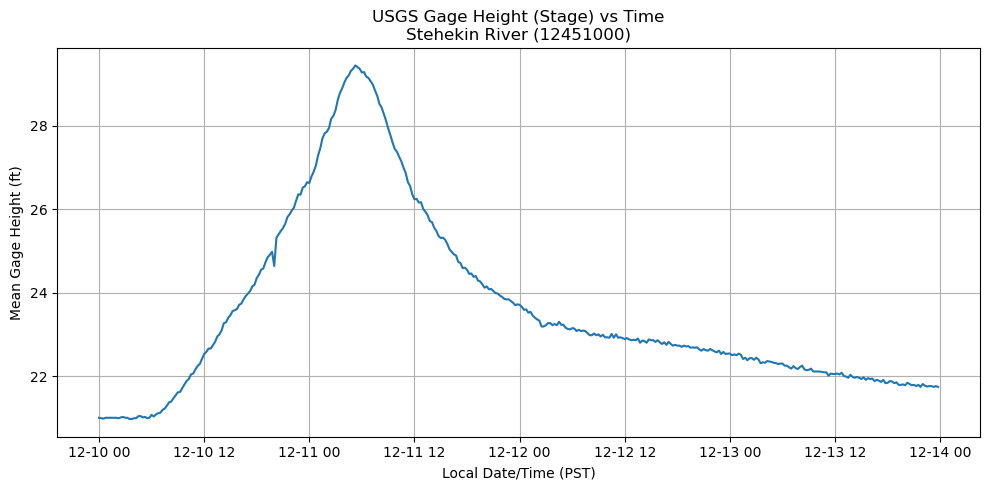

In [43]:
plt.figure(figsize=(10, 5))
plt.plot(df['datetime'], df['Gage Height (ft)'])
plt.xlabel('Local Date/Time (PST)')
plt.ylabel('Mean Gage Height (ft)')
plt.title("USGS Gage Height (Stage) vs Time\nStehekin River (12451000)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Climate Data
looking at December rainfall rates over years with recorded data

## Data Access

In [44]:
# Define API URL
url = "https://waterservices.usgs.gov/nwis/iv/?sites=12451000&agencyCd=USGS&startDT=1970-12-01T00:00:00.000-08:00&endDT=2025-12-31T23:59:59.999-08:00&parameterCd=00065&format=rdb"

# Download data
response = requests.get(url)
response.raise_for_status()  # Raise an error if the request failed

## Open Data

In [46]:
# suggested by ChatGPT for USGS .rdb files (legacy file type)
df = pd.read_csv(
    StringIO(response.text),
    sep="\t",
    comment="#",
    skiprows=[1]   # skip the format-spec line
)

print(df.head())
print(df.columns)

  agency_cd   site_no          datetime tz_cd 151780_00065 151780_00065_cd
0        5s       15s               20d    6s          14n             10s
1      USGS  12451000  2007-10-01 01:00   PDT        19.40               A
2      USGS  12451000  2007-10-01 01:15   PDT        19.40               A
3      USGS  12451000  2007-10-01 01:30   PDT        19.39               A
4      USGS  12451000  2007-10-01 01:45   PDT        19.39               A
Index(['agency_cd', 'site_no', 'datetime', 'tz_cd', '151780_00065',
       '151780_00065_cd'],
      dtype='object')


C:\Users\abchu\AppData\Local\Temp\ipykernel_29268\3675216702.py:2: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


## Clean Data

In [47]:
df = df.iloc[1:].reset_index(drop=True) # ChatGPT recommends dropping this format spec row from the dataframe (df) 

df["datetime"] = pd.to_datetime(df["datetime"]) # ChatGPT recommends converting datetime to numeric values

df["151780_00065"] = pd.to_numeric(df["151780_00065"], errors="coerce") # ChatGPT recommends converting stage (gage height) values to numeric values

df = df.rename(columns={"151780_00065": "Gage Height (ft)"}) # rename column title to something more easily understood

# check data again
print(df.head())
print(df.columns)

  agency_cd   site_no            datetime tz_cd  Gage Height (ft)  \
0      USGS  12451000 2007-10-01 01:00:00   PDT             19.40   
1      USGS  12451000 2007-10-01 01:15:00   PDT             19.40   
2      USGS  12451000 2007-10-01 01:30:00   PDT             19.39   
3      USGS  12451000 2007-10-01 01:45:00   PDT             19.39   
4      USGS  12451000 2007-10-01 02:00:00   PDT             19.39   

  151780_00065_cd  
0               A  
1               A  
2               A  
3               A  
4               A  
Index(['agency_cd', 'site_no', 'datetime', 'tz_cd', 'Gage Height (ft)',
       '151780_00065_cd'],
      dtype='object')


## Plot

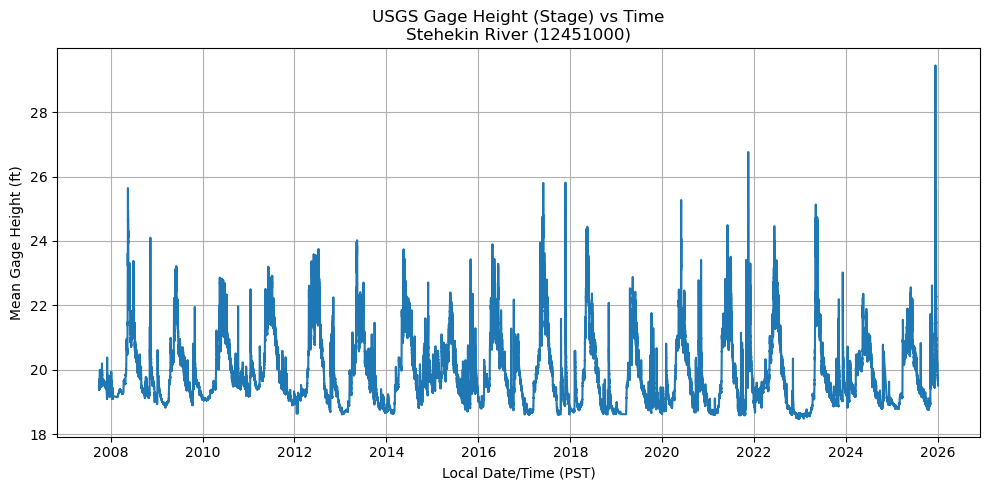

In [48]:
plt.figure(figsize=(10, 5))
plt.plot(df['datetime'], df['Gage Height (ft)'])
plt.xlabel('Local Date/Time (PST)')
plt.ylabel('Mean Gage Height (ft)')
plt.title("USGS Gage Height (Stage) vs Time\nStehekin River (12451000)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Climatic Context for Dec. 2025 Event
The Dec. 2025 flooding event in Stehekin, WA appears to be the most significant flooding event at this stream gage location since 2007, which was the earliest records USGS has of stream gage measurements at this location. The large amount of precipiation brought by the atmospheric river could raise river levels be itself, but the recent burned land and debris associated with the fires that occured in the region/watershed may have contributed to the elevated flood levels compared to previous yeras due to debris blocking river flow.

## Discharge Plots

In [ ]:
##Sofia's try at URL

url = 'https://waterservices.usgs.gov/nwis/iv/?format=rdb&sites=12451000&parameterCd=00060&startDT=2025-12-01&endDT=2025-12-31'

# Download data
response = requests.get(url)
response.raise_for_status()  # Raise an error if the request failed

# Split into lines and filter out comments
lines = response.text.split('\n')
data_lines = [line for line in lines if not line.startswith('#')]

# The first line is headers, second line is data types (skip it), rest is data
header = data_lines[0]
data = '\n'.join([header] + data_lines[2:])  # Skip the format descriptor row

# Read into DataFrame
stream_data = pd.read_csv(
    StringIO(data),
    sep="\t",
    parse_dates=["datetime"]
)

# Streamflow column has weird name, this code finds it based on API
# Find the streamflow column (parameter code 00060, without _cd suffix)
streamflow_col = [col for col in stream_data.columns if '00060' in col and not col.endswith('_cd')][0]

print(f"Streamflow column: {streamflow_col}")
print(f"Units: cubic feet per second (cfs)")

# Rename column for clarity
stream_data = stream_data.rename(columns={streamflow_col: 'discharge_cfs'})

# Removing weird and unnecesary column
stream_data = stream_data.drop(columns=['151779_00060_cd'])

stream_data.head()

In [ ]:
##Sofia: Using JSON format to get metadata

# Use JSON format to get metadata
url_json = 'https://waterservices.usgs.gov/nwis/iv/?format=json&sites=12451000&parameterCd=00060&startDT=2025-12-01&endDT=2025-12-31'

response = requests.get(url_json)
data = response.json()

# Extract units from the metadata
time_series = data['value']['timeSeries'][0]
variable = time_series['variable']

print(f"Parameter: {variable['variableName']}")
print(f"Description: {variable['variableDescription']}")
print(f"Unit: {variable['unit']['unitCode']}")

In [ ]:
# Sofia: Making plot for streamgauge data

plt.figure(figsize=(12, 6))
plt.plot(stream_data['datetime'], stream_data['discharge_cfs'], linewidth=1)

plt.xlabel('Date')
plt.ylabel('Discharge (cfs)')
plt.title('Streamflow - USGS Site 12451000')

# Set major gridlines to daily
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()